In [8]:
from mysql.connector import errorcode
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def connect(host, database, user, password):

    try:
        connection = mysql.connector.connect(host=host, database=database, user=user, password=password)
        if connection != None:
            return connection          
        
    except mysql.connector.Error as error:    
        if error.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database não existe")
                    
        if error.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Usuáro ou  senha  está errado")
            print(error)       
    return 
      
def execute_query(connection, query:str, data:tuple=''):

    try:
        cursor = connection.cursor()
        if data != '':
            cursor.execute(query, data)
            result = cursor.fetchall()
            connection.commit()
        else: 
            cursor.execute(query)
            result = cursor.fetchall()
            connection.commit()
                    
            return result 
    except mysql.connector.Error as error:
        return "Erro: {}".format(error.msg)
    finally:
        if connection.is_connected:
            connection.close()
            
def loop_result(results):
    from_db = []
    
    for result in results:
        result = list(result)
        from_db.append(result)
        
    if from_db != None:
        return from_db
    return

In [96]:
connection = connect('localhost','csgo','root','Retro.150')
query = '''SELECT * FROM results;'''
columns = ["Date_", "team_1", "team_2", "_map", "result_1", "result_2", "map_winner", "starting_ct", "ct_1", "t_2", "t_1", "ct_2", "event_id", "match_id", "rank_1", 
 "rank_2", "map_wins_1", "map_wins_2", "match_winner"]

results_results = execute_query(connection=connection, query=query)
df = pd.DataFrame(loop_result(results_results), columns=columns)
display(df)

In [97]:
# Gera dois novos DataFrames para os times das colunas "team_1" e "team_2"
df1 = pd.DataFrame(df, columns=['team_1', 'map_wins_1', 'map_wins_2'])
df2 = pd.DataFrame(df, columns=['team_2', 'map_wins_1', 'map_wins_2'])

# Novo dataframe que compara as colunas "map_wins_1" e "map wins_2" para saber em quais casos o time 1 ganhou.
team_1_w = pd.DataFrame(df1.query('map_wins_1 > map_wins_2'), columns=['team_1'])

# Após filtrar as linhas, uma nova variável DataFrame gera uma tabela com o quantitativo de vitórias de cada
# time da coluna "team_1".
count_df1 = team_1_w['team_1'].value_counts().reset_index().rename(columns={'index': 'team_1', 'team_1': 'count'})
display(count_df1)

,team_1,count
0,Astralis,752
1,Liquid,706
2,TYLOO,688
3,Natus Vincere,628
4,Tricked,620
...,...,...
901,Magistra,2
902,walkover,2
903,1UP,2
904,ex-Mentality,2


In [98]:
# Realiza as mesmas operações do notebook acima, só que dessa vez, com a coluna "team_2"
team_2_w = pd.DataFrame(df2.query('map_wins_1 < map_wins_2'), columns=['team_2'])
count_df2 = team_2_w['team_2'].value_counts().reset_index().rename(columns={'index': 'team_2', 'team_2': 'count'})
display(count_df2)

,team_2,count
0,mousesports,554
1,Liquid,532
2,G2,524
3,fnatic,468
4,Spirit,458
...,...,...
931,Wizards,2
932,Normal People and Rustun,2
933,Shadows,2
934,Operation Kino,2


In [101]:
# Nessa ultima parte, ambas as tabelas são unificadas e o valor de vitórias é somado caso o time apareça nas duas
count_df = pd.concat([count_df1, count_df2], axis=0).groupby('team_1')['count'].sum().reset_index()
count_df.columns = ['team', 'count']

# Após a unificação das tabelas, o comando abaixo ordena os times de forma decrescente, pela quantidade de vitórias
sorted_count_df = count_df.sort_values(by='count', ascending=False)
display(sorted_count_df)

,team,count
72,Astralis,752
418,Liquid,706
696,TYLOO,688
482,Natus Vincere,628
718,Tricked,620
...,...,...
193,Downfall,2
66,ArkAngel,2
775,WinOut,2
637,Saltbae,2


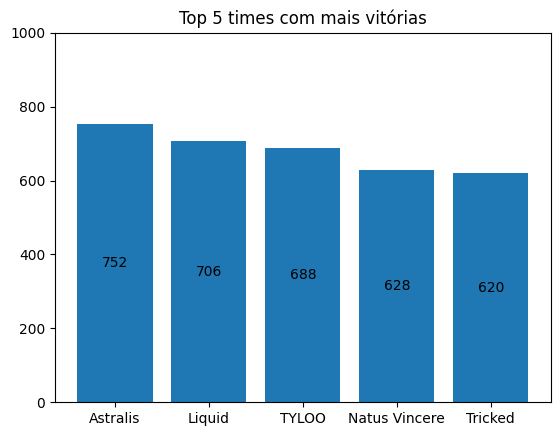

In [110]:
# Cógido para gerar o gráfico abaixo, podemos ver que entre 2015 e 2020, a Astralis foi o time que mais venceu mapas
fig, ax = plt.subplots()
bar_container = ax.bar(sorted_count_df['team'].head(5), sorted_count_df['count'].head(5))
ax.set(title='Top 5 times com mais vitórias', ylim=(0, 1000))
ax.bar_label(bar_container, label_type='center')
plt.show()